In [1]:
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from sklearn import metrics
import datetime
from finta import TA

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)
    return keras.Model(inputs, outputs)

In [2]:
def to_sequences(seq_size, obs, target_col):
    x = []
    y = []

    for i in range(len(obs)-seq_size):
        window = obs.iloc[i:(i+seq_size), target_col:].values
        after_window = obs.iloc[i+seq_size, target_col]
        window = [[x] for x in window]
        x.append(window)
        y.append(after_window)
        
    x_train = np.array(x)
    y_train = np.array(y)
    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[3]))
    
    return x_train, y_train

In [3]:
def prep_data(df,target_col, num_train):
    df_train = df.iloc[:num_train, :]
    df_test = df.iloc[num_train:, :]

    x_train = df_train.drop(target_col, axis=1)
    y_train = df_train[target_col]

    x_test = df_test.drop(target_col, axis=1)
    y_test = df_test[target_col]

    y_train = y_train.to_numpy().reshape((-1,1))
    y_test = y_test.to_numpy().reshape((-1,1))

    x_train, y_train = to_sequences(50, df_train, 0)
    x_test, y_test = to_sequences(50, df_test, 0)

    print(x_train.shape)

    input_shape = x_train.shape[1:]
    start = datetime.datetime.now()
    model = build_model(
        input_shape,
        head_size=256,
        num_heads=4,
        ff_dim=4,
        num_transformer_blocks=4,
        mlp_units=[128],
        mlp_dropout=0.4,
        dropout=0.25,
    )

    model.compile(
        loss="mean_squared_error",
        optimizer=keras.optimizers.Adam(learning_rate=1e-4)
    )

    model.summary()

    callbacks = [keras.callbacks.EarlyStopping(patience=10, \
        restore_best_weights=True)]

    model.fit(
        x_train,
        y_train,
        validation_split=0.2,
        epochs=20,
        batch_size=64,
        callbacks=callbacks,
    )
    finish = datetime.datetime.now()
    print("time to execute = ",finish-start)

    return model, x_test, y_test

In [4]:
CAPITAL = 3.27
# Get the baseline capital
def backtest(pred, y_test, df, periods_per_day, target_col):
    total   = 0
    pnls    = []
    counter = 0

    df = df.set_index('Date').copy()

    idx = list(df[target_col].index)
    idx_n = []

    for x in range(len(pred)):
        if pred[x][0] > 0.0:
            total += y_test[x]
        elif pred[x][0] < 0.0:
            total -= y_test[x]
        if (counter % periods_per_day == 0):
            pnls.append(total)
            idx_n.append(idx[counter])
        counter += 1

    rets = pd.DataFrame(data=pnls, columns=['cum_pnl'], index=idx_n)
    rets['portfolio'] = rets['cum_pnl'] + CAPITAL 
    rets['pct_pnl'] = rets['portfolio'].pct_change()
    rets = rets.dropna()

    return rets

In [5]:
import matplotlib.pyplot as plt

def perf_summ(
    data: pd.DataFrame, adj: int = 12, title="Metric"
) -> pd.DataFrame:
    summary = pd.DataFrame(
        data=data.mean() * adj, index=[title], columns=["Annualized Return"]
    )
    summary["Annualized Volatility"] = data.std() * np.sqrt(adj)
    summary["Annualized Sharpe Ratio"] = (
        summary["Annualized Return"] / summary["Annualized Volatility"]
    )
    summary["Annualized Sortino Ratio"] = summary["Annualized Return"] / (
        (data[data < 0]).std() * np.sqrt(adj)
    )

    summary["Skewness"] = data.skew()
    summary["Kurtosis"] = data.kurtosis()
    summary["VaR (0.05)"] = data.quantile(0.05)
    summary["CVaR (0.05)"] = data[data <= data.quantile(0.05)].mean()
    summary["Min"] = data.min()
    summary["Max"] = data.max()

    wealth_index = 1000 * (1 + data).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks) / previous_peaks

    summary["Max Drawdown"] = drawdowns.min()
    summary["Calmar Ratio"] = data.mean()/drawdowns.min()

    return summary.T

Original data

In [6]:
periods_per_day = 10
fn = "qm_data_tufv.csv"
df = pd.read_csv(fn, sep=',', na_values=['-1'], index_col=False)

target_col = 'fut'

# Taking sin and cos of hour (from: https://github.com/nklingen/Transformer-Time-Series-Forecasting)
df['Date'] = pd.to_datetime(df['Date'])
df['CosHour'] = np.cos(2*np.pi*df['Date'].dt.hour/24)
df['SinHour'] = np.sin(2*np.pi*df['Date'].dt.hour/24)
col = df.pop(target_col)
df.insert(0, col.name, col)
df_f = df.drop(['Sum', 'Date'], axis=1).dropna()

model_o, x_test_o, y_test_o = prep_data(df_f,target_col, num_train=6_000)

(5950, 50, 21)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 21)]     0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 50, 21)      42          ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 50, 21)      89109       ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
                                                                               

In [7]:
model_o.evaluate(x_test_o, y_test_o, verbose=1)
pred = model_o.predict(x_test_o)
score = np.sqrt(metrics.mean_squared_error(pred,y_test_o))
print("Score (RMSE): {}".format(score))

59/59 [==============================] - 1s 4ms/step
Score (RMSE): 0.027433721307603097


In [8]:
rets = backtest(pred, y_test_o, df, periods_per_day, target_col)

,Window=50
Annualized Return,0.289767
Annualized Volatility,0.288344
Annualized Sharpe Ratio,1.004936
Annualized Sortino Ratio,1.669379
Skewness,0.145337
Kurtosis,1.087273
VaR (0.05),-0.028385
CVaR (0.05),-0.037626
Min,-0.056415
Max,0.064720


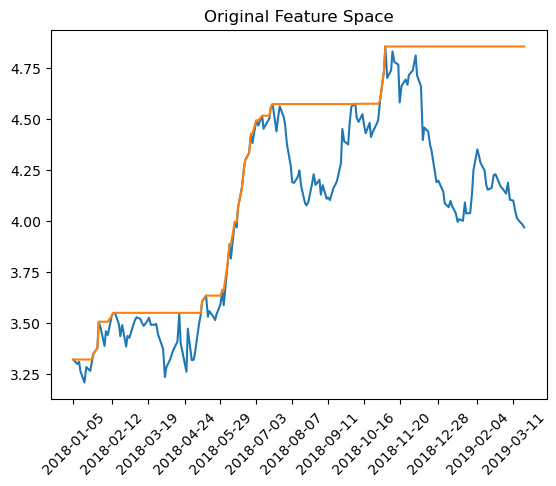

In [9]:
display(perf_summ(rets['pct_pnl'], adj=252, title="Window=50"))
agg_perf = perf_summ(rets['pct_pnl'], adj=252, title="Transformer")
plt.plot(rets['portfolio'])
plt.plot(rets['portfolio'].cummax())
plt.title('Original Feature Space')
plt.xticks(ticks=rets.index[::15], rotation=45)
plt.show()

PCA Decomposition

In [10]:
from sklearn.decomposition import PCA 
import seaborn as sns

fn = "qm_data_tufv.csv"
df = pd.read_csv(fn, sep=',', na_values=['-1'], index_col=0)

X = df.drop(columns=['fut','Sum'])
X = X.dropna()

<AxesSubplot: >

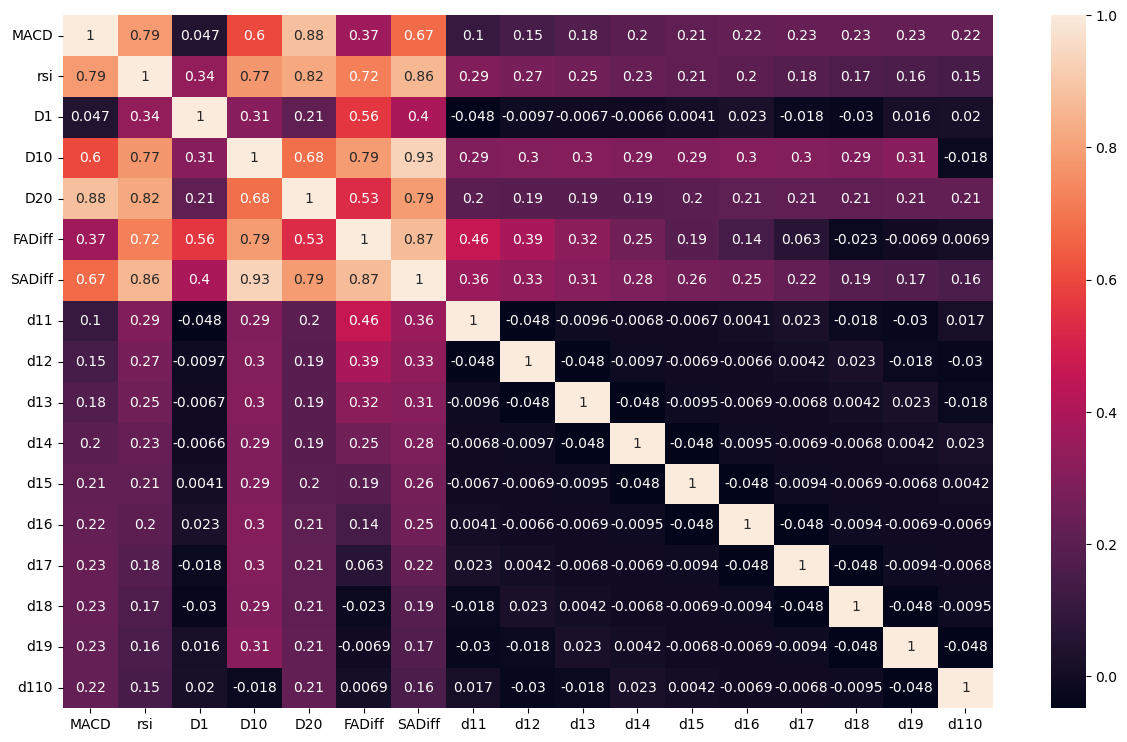

In [11]:
plt.figure(figsize=(15,9))
sns.heatmap(X.drop(columns=['time']).corr(), annot=True)

assuming the scales of all the features can be compared like this

- a high feature space can be prone to overfitting, so let's perform PCA to reduce dimensionality

In [12]:
from sklearn.decomposition import PCA 

fn = "qm_data_tufv.csv"
df = pd.read_csv(fn, sep=',', na_values=['-1'], index_col=0)

X = df.drop(columns=['fut','Sum'])
X = X.dropna()

pca = PCA(n_components=2)  # We will choose 2 principal components
X = X.dropna()
comps = pca.fit_transform(X)

transformed_data = pd.DataFrame(comps,index=df.index)
transformed_data = pd.concat([df['fut'],transformed_data],axis=1)
transformed_data = transformed_data.dropna().reset_index()

# A copy of a version of  transformed data is also present in the files (new_features1.csv)

In [14]:
periods_per_day = 10
#fn = "new_features1.csv"
#df = pd.read_csv(fn, sep=',', na_values=['-1'], index_col=False)

df = transformed_data 
target_col = 'fut'
df['Date'] = pd.to_datetime(df['Date'])
df['CosHour'] = np.cos(2*np.pi*df['Date'].dt.hour/24)
df['SinHour'] = np.sin(2*np.pi*df['Date'].dt.hour/24)
col = df.pop(target_col)
df.insert(0, col.name, col)
df_f = df.dropna().drop(columns=['Date'])

model_pca, x_test_pca, y_test_pca = prep_data(df_f,target_col,num_train=6_000)

(5950, 50, 5)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 50, 5)]      0           []                               
                                                                                                  
 layer_normalization_8 (LayerNo  (None, 50, 5)       10          ['input_2[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 multi_head_attention_4 (MultiH  (None, 50, 5)       23557       ['layer_normalization_8[0][0]',  
 eadAttention)                                                    'layer_normalization_8[0][0]']  
                                                                              

In [15]:
model_pca.evaluate(x_test_pca, y_test_pca, verbose=1)
pred = model_pca.predict(x_test_pca)
score = np.sqrt(metrics.mean_squared_error(pred,y_test_pca))
print("Score (RMSE): {}".format(score))

59/59 [==============================] - 0s 4ms/step
Score (RMSE): 0.08347434785655146


,PCA Transformer
Annualized Return,0.464009
Annualized Volatility,0.331839
Annualized Sharpe Ratio,1.398296
Annualized Sortino Ratio,2.779859
Skewness,0.543203
Kurtosis,0.404771
VaR (0.05),-0.028510
CVaR (0.05),-0.034957
Min,-0.046277
Max,0.073843


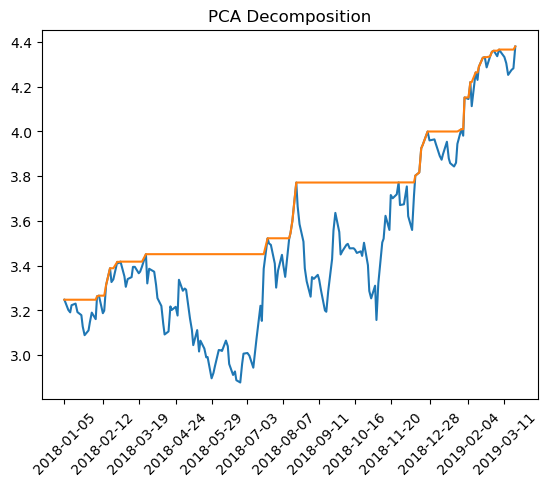

In [16]:
rets = backtest(pred, y_test_pca, df, periods_per_day, target_col)
display(perf_summ(rets['pct_pnl'], adj=252, title="PCA Transformer"))
agg_perf['PCA Transformer'] = perf_summ(rets['pct_pnl'], adj=252, title="PCA Transformer")

plt.plot(rets['portfolio'])
plt.plot(rets['portfolio'].cummax())
plt.xticks(ticks=rets.index[::15], rotation=45)
plt.title('PCA Decomposition')
plt.show()

How does it compare with XGBoost?

In [17]:
# How does it compare with an XGBoost model?
fn = "qm_data_tufv.csv"
df_o = pd.read_csv(fn, sep=',', na_values=['-1'], index_col=False)
target_col = 'fut'
periods_per_day = 10
df_o['Date'] = pd.to_datetime(df_o['Date'])
df_o['CosHour'] = np.cos(2*np.pi*df_o['Date'].dt.hour/24)
df_o['SinHour'] = np.sin(2*np.pi*df_o['Date'].dt.hour/24)
col = df_o.pop(target_col)
df_o.insert(0, col.name, col)
df_fo = df_o.drop(columns=['Date', 'Sum']).dropna()

,Window=50
Annualized Return,0.216901
Annualized Volatility,0.331615
Annualized Sharpe Ratio,0.654073
Annualized Sortino Ratio,1.071260
Skewness,0.222331
Kurtosis,0.580125
VaR (0.05),-0.032418
CVaR (0.05),-0.042058
Min,-0.051868
Max,0.066184


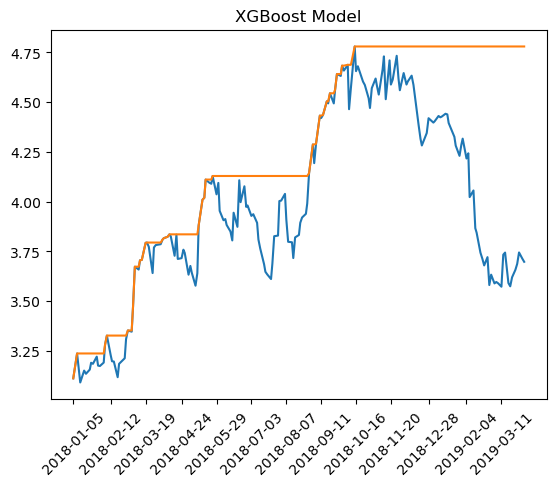

In [19]:
import xgboost as xgb

df_f_train = df_fo.iloc[:6_000, :]
df_f_test = df_fo.iloc[6_000:, :]

X_train = df_f_train.drop(columns=['fut'])
y_train = df_f_train['fut']
X_test = df_f_test.drop(columns=['fut'])
y_test = df_f_test['fut']

regr = xgb.XGBRegressor()
regr.fit(X_train, y_train)
yhat = regr.predict(X_test)

xgb_res = backtest(yhat.reshape(-1, 1), y_test.reset_index(drop=True), df_o, periods_per_day, target_col)

display(perf_summ(xgb_res['pct_pnl'], adj=252, title="Window=50"))

agg_perf = perf_summ(xgb_res['pct_pnl'], adj=252, title="XGBoost Model")

plt.plot(xgb_res['portfolio'])
plt.plot(xgb_res['portfolio'].cummax())
plt.xticks(ticks=xgb_res.index[::15], rotation=45)
plt.title('XGBoost Model')
plt.show()

Future prices have virtually no autocorrelation.

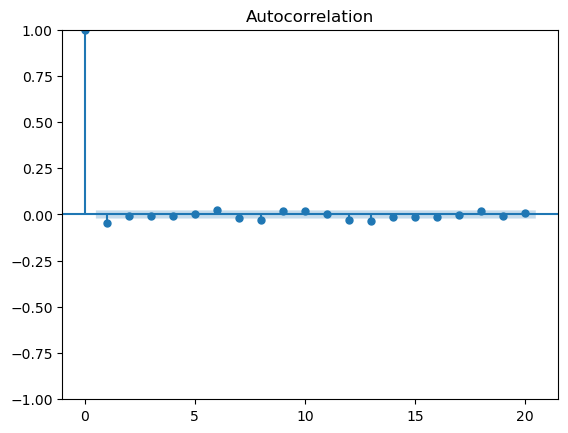

In [21]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf = plot_acf(df_fo['fut'], lags=20)

Both MACD and RSI do (this is to be expected given they are used to smooth the data).

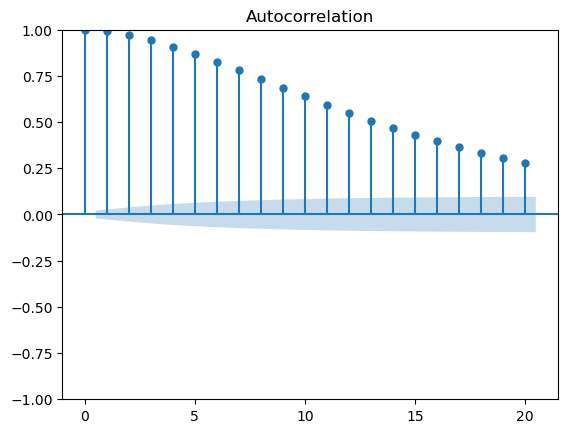

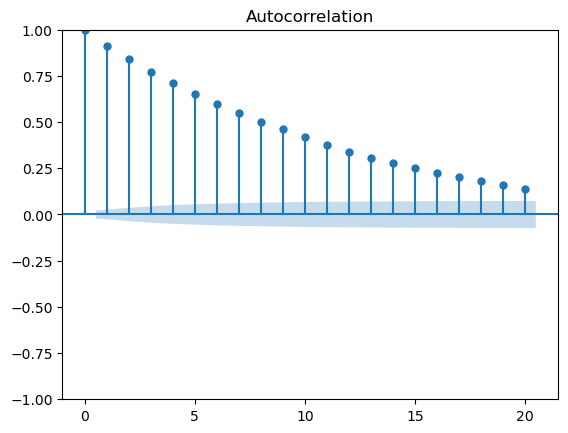

In [22]:
acf = plot_acf(df_fo['MACD'], lags=20)
acf = plot_acf(df_fo['rsi'], lags=20)

,Window=50
Annualized Return,0.458349
Annualized Volatility,0.290440
Annualized Sharpe Ratio,1.578121
Annualized Sortino Ratio,2.735696
Skewness,0.178707
Kurtosis,0.194420
VaR (0.05),-0.028964
CVaR (0.05),-0.034153
Min,-0.048121
Max,0.055087


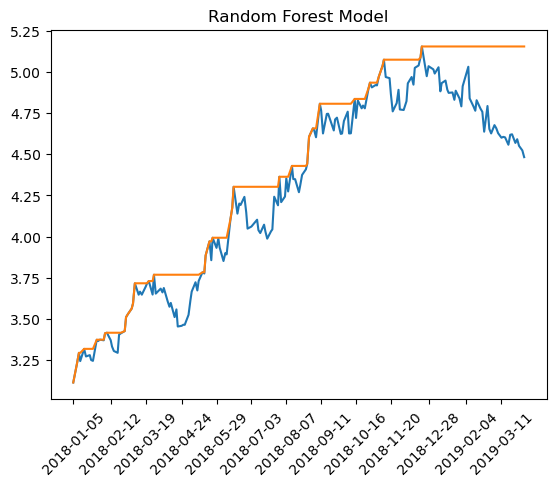

In [24]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators=1000, random_state=1)
forest.fit(X_train, y_train)
forest_pred = forest.predict(X_test)

forest_res = backtest(forest_pred.reshape(-1, 1), y_test.reset_index(drop=True), df_o, periods_per_day, target_col)
display(perf_summ(forest_res['pct_pnl'], adj=252, title="Window=50"))

agg_perf['Random Forest'] = perf_summ(forest_res['pct_pnl'], adj=252, title="Random Forest Model")

plt.plot(forest_res['portfolio'])
plt.plot(forest_res['portfolio'].cummax())
plt.xticks(ticks=forest_res.index[::15], rotation=45)
plt.title('Random Forest Model')
plt.show()

,Window=50
Annualized Return,0.449844
Annualized Volatility,0.288677
Annualized Sharpe Ratio,1.558298
Annualized Sortino Ratio,2.765327
Skewness,0.309979
Kurtosis,1.321768
VaR (0.05),-0.025589
CVaR (0.05),-0.034310
Min,-0.055722
Max,0.073859


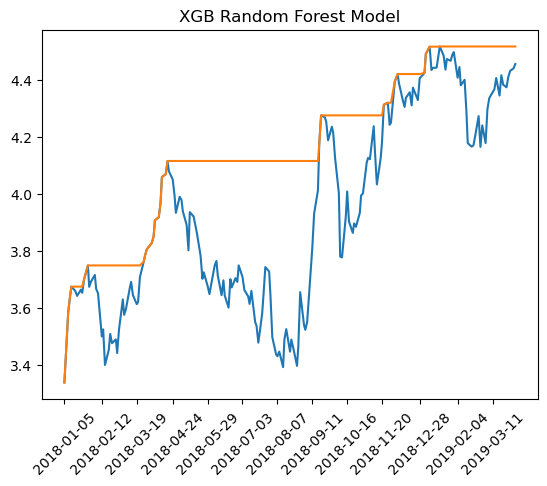

In [25]:
# What about XGBOOST with a random forest?
xgb_for = xgb.XGBRFRegressor()
xgb_mod = xgb_for.fit(X_train, y_train)
xgb_mod_pred = xgb_mod.predict(X_test)
xgb_res = backtest(xgb_mod_pred.reshape(-1, 1), y_test.reset_index(drop=True), df_o, periods_per_day, target_col)

display(perf_summ(xgb_res['pct_pnl'], adj=252, title="Window=50"))

agg_perf['XGB Random Forest'] = perf_summ(xgb_res['pct_pnl'], adj=252, title="XGB Random Forest Model")

plt.plot(xgb_res['portfolio'])
plt.plot(xgb_res['portfolio'].cummax())
plt.xticks(ticks=xgb_res.index[::15], rotation=45)
plt.title('XGB Random Forest Model')
plt.show()

In [26]:
# Repeat but with PCA.
df = transformed_data 
target_col = 'fut'
df['Date'] = pd.to_datetime(df['Date'])
df['CosHour'] = np.cos(2*np.pi*df['Date'].dt.hour/24)
df['SinHour'] = np.sin(2*np.pi*df['Date'].dt.hour/24)
col = df.pop(target_col)
df.insert(0, col.name, col)
df_f = df.dropna().drop(columns=['Date'])
df_f = df_f.rename({0: 'PCA1', 1: 'PCA2'}, axis=1)

In [27]:
X_train, X_test, y_train, y_test = df_f.iloc[:6000, 1:], df_f.iloc[6000:, 1:], df_f.iloc[:6000, 0], df_f.iloc[6000:, 0]

,Window=50
Annualized Return,0.018761
Annualized Volatility,0.306778
Annualized Sharpe Ratio,0.061155
Annualized Sortino Ratio,0.095955
Skewness,0.035539
Kurtosis,0.507487
VaR (0.05),-0.032062
CVaR (0.05),-0.041405
Min,-0.048966
Max,0.064236


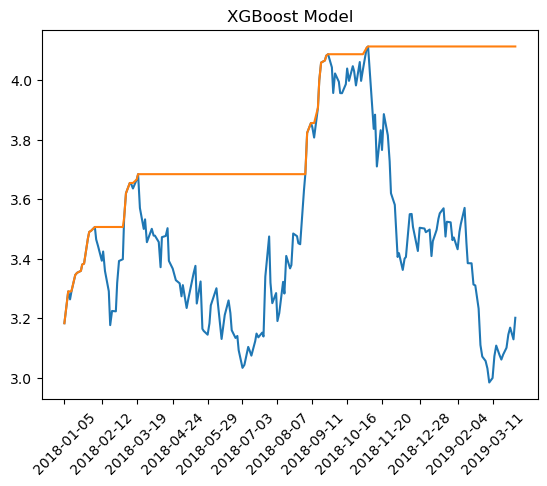

In [28]:
regr = xgb.XGBRegressor()
regr.fit(X_train, y_train)
yhat = regr.predict(X_test)

xgb_res = backtest(yhat.reshape(-1, 1), y_test.reset_index(drop=True), df, periods_per_day, target_col)

display(perf_summ(xgb_res['pct_pnl'], adj=252, title="Window=50"))

agg_perf['PCA XGBoost'] = perf_summ(xgb_res['pct_pnl'], adj=252, title="PCA XGBoost Model")

plt.plot(xgb_res['portfolio'])
plt.plot(xgb_res['portfolio'].cummax())
plt.xticks(ticks=xgb_res.index[::15], rotation=45)
plt.title('XGBoost Model')
plt.show()

,Window=50
Annualized Return,0.072929
Annualized Volatility,0.294158
Annualized Sharpe Ratio,0.247923
Annualized Sortino Ratio,0.367026
Skewness,-0.263688
Kurtosis,1.707851
VaR (0.05),-0.028115
CVaR (0.05),-0.040533
Min,-0.074266
Max,0.071484


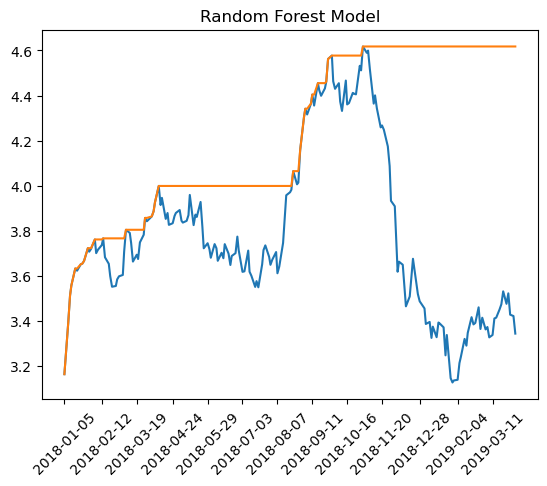

In [29]:
forest = RandomForestRegressor(n_estimators=1000, random_state=1)
forest.fit(X_train, y_train)
forest_pred = forest.predict(X_test)

forest_res = backtest(forest_pred.reshape(-1, 1), y_test.reset_index(drop=True), df_o, periods_per_day, target_col)
display(perf_summ(forest_res['pct_pnl'], adj=252, title="Window=50"))

agg_perf['PCA Random Forest'] = perf_summ(forest_res['pct_pnl'], adj=252, title="PCA Random Forest Model")

plt.plot(forest_res['portfolio'])
plt.plot(forest_res['portfolio'].cummax())
plt.xticks(ticks=forest_res.index[::15], rotation=45)
plt.title('Random Forest Model')
plt.show()

In [30]:
display(agg_perf)

,XGBoost Model,Random Forest,XGB Random Forest,PCA XGBoost,PCA Random Forest
Annualized Return,0.216901,0.458349,0.449844,0.018761,0.072929
Annualized Volatility,0.331615,0.290440,0.288677,0.306778,0.294158
Annualized Sharpe Ratio,0.654073,1.578121,1.558298,0.061155,0.247923
Annualized Sortino Ratio,1.071260,2.735696,2.765327,0.095955,0.367026
Skewness,0.222331,0.178707,0.309979,0.035539,-0.263688
Kurtosis,0.580125,0.194420,1.321768,0.507487,1.707851
VaR (0.05),-0.032418,-0.028964,-0.025589,-0.032062,-0.028115
CVaR (0.05),-0.042058,-0.034153,-0.034310,-0.041405,-0.040533
Min,-0.051868,-0.048121,-0.055722,-0.048966,-0.074266
Max,0.066184,0.055087,0.073859,0.064236,0.071484


In [ ]:
# Leaving this in for later  -- AR1 model.
# from statsmodels.tsa.ar_model import AutoReg
# ar_model = AutoReg(endog=y_train, exog=X_train, lags=1).fit()
# ar_model.summary()
#preds = ar_model.predict(start=5999, end=len(X_test) + 5999, exog=X_train, exog_oos=X_test)
#ar_model.params[0] + X_test @ ar_model.params[1:]